In [3]:
import autograd as autograd 
from autograd import numpy as np 
import matplotlib.pyplot as plt
from mpl_toolkits.mplot3d import Axes3D

%matplotlib inline

#### Quelques Fonctions

In [4]:
g = lambda X : (X[1])**2 +(X[0])**2

In [5]:
g1=lambda X : np.exp(-X[0]**2-X[1]**2)
g2=lambda X : np.exp( -(X[0]-1)**2-(X[1]-1)**2)

def f(X):
    return 2*(np.exp(-X[0]**2-X[1]**2)-np.exp( -(X[0]-1)**2-(X[1]-1)**2))


# Projet Maths info
## Courbes de niveau 



# Déceler une amorce
On souhaite déterminer une solution de l'équation $f(x,y)=c$ sur le bord gauche de la surface $[0,1]^2$ 
### Méthode de Newton à 1D pour des fonctions de 1 variable
- Soit $f: [0,1]² \to \mathbb{R}$ on considère $f \in C^1$, Soit $x=0$  considérons $ g:[0,1] \to \mathbb{R} , y \mapsto f(x,y)$ la fonction à une seule variable.
- Résolvons l'équation $g(y)=c$ sur $[0,1]$ :
    - Pour ce faire utilisons la méthode de Newton qui nous dit, en supposant que la fonction est différentiable et que sa dérivéee ne s'annule pas sur $[0,1]$,  que la suite $(_k)_\mathbb{N}$ définie par $ y_{k+1}=y_{k} -\frac{g(x_k)}{g'(x_{k})}$ est convrgente et de limite y solution de l'équation $g(y)=c$
- On implémente ainsi l'algorithme de résolution d'équation en construisant itérativement la suite.
- On considère la limite atteinte lorsque la distance entre deux $x_k$ successifs est plus petit qu'un certain $\epsilon$ fixé


In [6]:
def find_seed_newt(g,c=0,eps=2**(-26)):
    if (g([0,1])-c)*(g([0,0])-c)>0:
        return None
    else : 
        gradg = autograd.grad(g)
        x_0 = 5
        x = x_0 -(g(np.array([0.,x_0]))-c)/gradg(np.array([0.,x_0]))[1]
        while abs(x-x_0) > eps:
            x_0 = x
            x = x_0-(g(np.array([0,x_0]))-c)/gradg(np.array([0,x_0]))[1]
        return [0,x]

In [7]:
find_seed_newt(g,1)

[0, 1.0]

### Recherche Dichotomique 

- Mais la méthode de Newton paye sa grande rapidité de convergence par une faible stabilité, en effet il faut trouver une amorce qui est assez proche du point de convergence. Sinon la suite des ($y_k$) diverge 
- De plus cette méthode n'est pas appliquable si à un moment on passe par un point où la dérivée s'annule

**On préferera donc dans la suite la méthode de recherche dichotomique qui un peu moins rapide mais qui converge à coup sur vers une solution quand il en existe une.** L'expérience a montré que plusieurs fois l'une des initialisation des fonctions `find_seed_X` se faisait en un point où la dérivée était nulle, ce qui rendait impossible la méthode de Newton

In [8]:
def find_seed_dicho (g,c=0,limx=[0.,1.],limy=[0.,1.],eps=2**(-26)):
    if (g([limx[0],limy[0]])-c)*(g([limx[0],limy[1]])-c)<=0 :
        a,b=limy[0],limy[1]
        if g([limx[0],a])>g([limx[0],b]):
            a,b=b,a
        while abs(b-a)>eps:
            d=(a+b)/2
            if (g([limx[0],d])-c)>0:
                b=d
            else:
                a=d
        return [limx[0],d]
    else :
        return None

In [9]:


find_seed_dicho(g,1.)

[0.0, 0.9999999850988388]

# Tracé de lignes de niveau
## Construction par cheminement

On utlise premièrement la propriété qui énonce qu'une certaine ligne de niveau est en tout point perpendiculaire au gradient.

- En effet soit {$\mathbb{R},(x(t),y(t))$} l'arc paramétré suivant la ligne de niveau tel quel $\forall t \in \mathbb{R}, f(x(t),y(t))=c$
    - Soit $x_0$ un point, on a alors d'après la régle de dérivation selon un arc $\dfrac{df(x(t),y(t))}{dt}=\nabla(f(x_0)).x'(t)=0$ D'où le gradient est Orthogonal à la tangente à la ligne de niveau en tous points.



- On part donc d'une amorce que l'on calcule avec la fonction  `find_seed` et on se déplace d'une distance delta selon la direction perpendiculaire au gradient en ce point. L'erreur s'accumule à chaque itération, mais l'implémentation est relativement aisée. Et une division de la zone de recherche en cellule permet d'éviter d'accumuler cette erreur sur une trop longue "distance"


- Cf. $Méthode\space d'Euler$ qui est d'ordre 1 


- On détermine $\begin{pmatrix} x_{0} \\ y_{0}\end{pmatrix}$ à l'aide de la fonction `find_seed`

- En considérant le Gradient $\overrightarrow{\text{grad}}\,f(\text{M})= \begin{pmatrix} 
\dfrac{\partial f}{\partial x} \\ 
 \dfrac{\partial f}{\partial y}
 \end{pmatrix}$ On en déduit que le vecteur directeur de la tangente à la ligne de niveau est : $\overrightarrow{V_\parallel}(\text{M})=\begin{pmatrix} 
\dfrac{\partial f}{\partial y} \\ 
-\dfrac{\partial f}{\partial x}
 \end{pmatrix}$
- On calcule les points de la courbe de niveau comme étant les points de la suite de formule de réccurence  : $M_{k+1}=\begin{pmatrix} x_{k+1} \\ y_{k+1}\end{pmatrix} = \begin{pmatrix} x_{k} \\ y_{k}\end{pmatrix} + \dfrac{\delta}{||\overrightarrow{\text{grad}}\,f(\text{M})||}.\begin{pmatrix}\dfrac{\partial f}{\partial y} \\ -\dfrac{\partial f}{\partial x} \end{pmatrix}$



In [10]:
def simple_contour (g,c=0,delta=0.01):
    abscisses,ordonnées =[],[]
    position=np.array(find_seed_newt(g,c))
    gradg=autograd.grad(g)
    abscisses.append(position[0])
    ordonnées.append(position[1])
    def test (position) :
        return 0<=position[0]<=1 and 0<=position[1]<=1
    
    while test(position) :
        gradX = gradg(position)
        norme = np.sqrt(gradX[1]**2+gradX[0]**2)
        vect = np.array([gradX[1]/norme,-1*gradX[0]/norme])
        position = position + vect*delta
        abscisses.append(position[0])
        ordonnées.append(position[1])
    return abscisses,ordonnées 


### Exemple de tracé

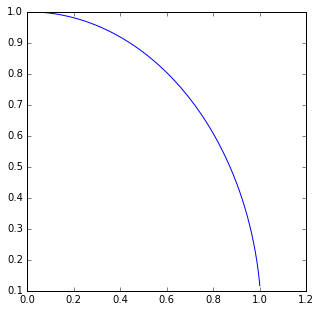

In [11]:
c=simple_contour(g,1,0.01)
plt.figure(figsize=(5,5))
plt.plot(c[0],c[1])

## Erreur accumulée
La méthode d'Euler est une méthode d'ordre 1 d'où la croissance linéaire de l'erreur avec les itérations. Un $\delta$  très petit minimise l'erreur sur un grand nombre d'itération. De plus on tachera au minimum de limiter les itérations de cette méthode en restreignant la zone d'étude afin d'éviter à l'erreur de s'accumuler. On peut tracer l'erreur au fur et à mesure de l'itération.

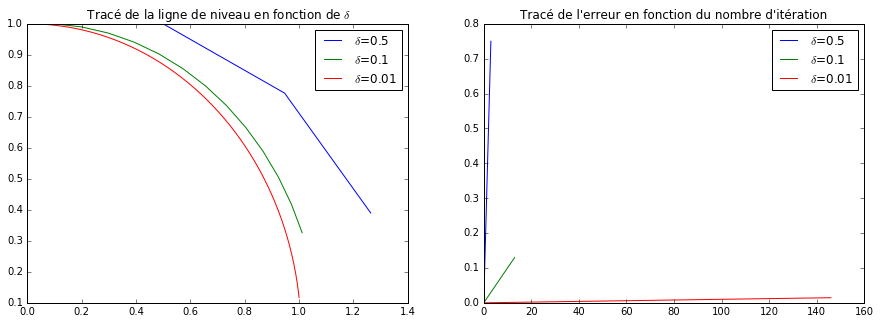

In [12]:
a=simple_contour(g,1,0.5)
b=simple_contour(g,1,0.1)
c=simple_contour(g,1,0.01)
plt.close()
plt.figure(figsize=(15,5))

plt.subplot(121)
plt.title(" Tracé de la ligne de niveau en fonction de $\delta$")
plt.plot(a[0],a[1],label='$\delta$=0.5')
plt.plot(b[0],b[1],label='$\delta$=0.1')
plt.plot(c[0],c[1],label='$\delta$=0.01')
plt.legend()
plt.subplot(122)
plt.plot((np.array(a[0])**2+np.array(a[1])**2)-1,label='$\delta$=0.5')
plt.plot((np.array(b[0])**2+np.array(b[1])**2)-1,label='$\delta$=0.1')
plt.plot((np.array(c[0])**2+np.array(c[1])**2)-1,label='$\delta$=0.01')
plt.title("Tracé de l'erreur en fonction du nombre d'itération")
plt.legend()



# $\Rightarrow$ on ne peut accepter une aussi grosse erreur

- A priori pour une observation graphique, cela ne poserait pas trop de problème. Mais en fait, il faut être plus précis. 


# Fonction de tracé
## Recherche d'amorce évoluée
On réecrit la fonction `find_seed_dicho` pour la rendre capable d'effectuer le test sur les quatres cotés de la zone. On ne priorise pas une amorce plutôt qu'une autre car dans le cadre de notre méthode, il est possible que l'orientation du Gradient fasse que la ligne de niveau soit dirigéee vers un point en dehors de la cellule
- On définit 4 fonctions de type `find_seed_dicho` mais qui sont écrites pour chacun des bords d'une cellule, elle prend en argument des informations supplémentaires qui permettront à la dichotomie de s'initialiser n'importe où dans la zone de recherche.



In [13]:
def find_seed_D (g,c=0,limx=[0.,1.],limy=[0.,1.],eps=2**(-26)):
    if (g([limx[1],limy[0]])-c)*(g([limx[0],limy[0]])-c)<0:
        a,b=limx[0],limx[1]
        if g([a,limy[0]])>g([b,limy[0]]):
            a,b=b,a
        while abs(b-a)>eps:
            d=(a+b)/2
            if (g([d,limy[0]])-c)>0:
                b=d
            else:
                a=d
        return [d,limy[0]]
    else :
        return None
def find_seed_L (g,c=0,limx=[0.,1.],limy=[0.,1.],eps=2**(-26)):
    if (g([limx[0],limy[0]])-c)*(g([limx[0],limy[1]])-c)<=0 :
        a,b=limy[0],limy[1]
        if g([limx[0],a])>g([limx[0],b]):
            a,b=b,a
        while abs(b-a)>eps:
            d=(a+b)/2
            if (g([limx[0],d])-c)>0:
                b=d
            else:
                a=d
        return [limx[0],d]
    else :
        return None


def find_seed_U (g,c=0,limx=[0.,1.],limy=[0.,1.],eps=2**(-26)):
    if (g([limx[0],limy[1]])-c)*(g([limx[1],limy[1]])-c)<=0 :
        a,b=limx[0],limx[1]
        if g([a,limy[1]])>g([b,limy[1]]):
            a,b=b,a
        while abs(b-a)>eps:
            d=(a+b)/2
            if (g([d,limy[1]])-c)>0:
                b=d
            else:
                a=d
        return [d,limy[1]]
    else:
        return None
    
def find_seed_R(g,c=0,limx=[0.,1.],limy=[0.,1.],eps=2**(-26)):
    if  (g([limx[1],limy[1]])-c)*(g([limx[1],limy[0]])-c)<=0 :
        a,b=limy[0],limy[1]
        if g([limx[1],a])>g([limx[1],b]):
            a,b=b,a
        while abs(b-a)>eps:
            d=(a+b)/2
            if (g([limx[1],d])-c)>0:
                b=d
            else:
                a=d
        return [limx[1],d]
    else:
        return None



## Construction évoluée
- Dans cette nouvelle fonction `simple_contour`, on prend en plus en argument le découpage en cellule de la plage de recherche, les coordonnées de la cellule dans lequel l'algorithme parent se trouve, ainsi que le bord de la cellule depuis lequel on souhaite initialiser l'algorithme.
- Cet algorithme n'est qu'une adaptation de la méthode présentéee dans la partie précédente. 

In [14]:
def simple_contour(g,xc,yc,nom_bord,i,j,c=0,delta=0.001):
    abscisses , ordonnées = [],[]
    dic_fonction = {"UP" : find_seed_U, "LEFT":find_seed_L, "RIGHT" : find_seed_R,"DOWN" : find_seed_D }
    position = dic_fonction[nom_bord](g,c,[xc[i],xc[i+1]], [yc[j],yc[j+1]])
    gradg=autograd.grad(g)
    if  not isinstance( position,list) :
        return [],[]
    else:
        position = np.array(position)        
        abscisses.append(position[0])
        ordonnées.append(position[1])
        def test (position):
            return xc[i]<=position[0]<=xc[i+1] and yc[j]<=position[1]<=yc[j+1]
        while test(position) :
            gradX=gradg(position)
            norme = np.sqrt(gradX[1]**2+gradX[0]**2)
            vect = np.array([gradX[1]/norme,-1*gradX[0]/norme])
            position = position + vect*delta

            abscisses.append(position[0])
            ordonnées.append(position[1])
        return abscisses,ordonnées

## Découpe et compilation des fragments

`contour_complexe` constitue le regroupement de `simple_contour` et des fonctions `find_seed_Lettre`.  
Xc et Yc (qui sont normalement égales) limitent un quadrillage.
On parcourt ce quadrillage en traçant pour chaque case un bout de ligne de niveau (s'il existe).
Une seule courbe de niveau sera obtenue par case, celle correspondant à la premièe amorce où la ligne de niveau est 'rentrante' dans la case.

On construit alors deux tableaux, Xs et Ys, qui contiennent les coordonées des points calculés. 



In [15]:
def contour_complexe(f, c=0, xc = [0,1], yc = [0,1], delta = 0.01):
    xs,ys= [], []

    liste_bord = ['UP','LEFT','RIGHT','DOWN']
    for i in range(len(xc)-1):
        for j in range(len(yc)-1):
            for nom_bord in liste_bord :
                X,Y=simple_contour(f,xc,yc,nom_bord,i,j,c,delta)
                xs.append(X)
                ys.append(Y)
    return xs,ys


## Tracé

- La fonction `trace` regroupe les deux tableaux, xs et ys, et trace case par case les section des courbes de niveau. 

- Le quadrillage est réalisé grâce à la fonction numpy `np.linspace()`. On s'assure ainsi un quadrillage régulier entre nos bornes. Ici, on trace directement les courbes de niveaux pour différentes valeurs. On superpose les graphes, et puis on edite. 

In [16]:
def trace(g,xc,yc,c=0):
    a,b=contour_complexe(g,c,xc,yc)
    for x,y in zip(a,b):
        plt.plot(x,y)

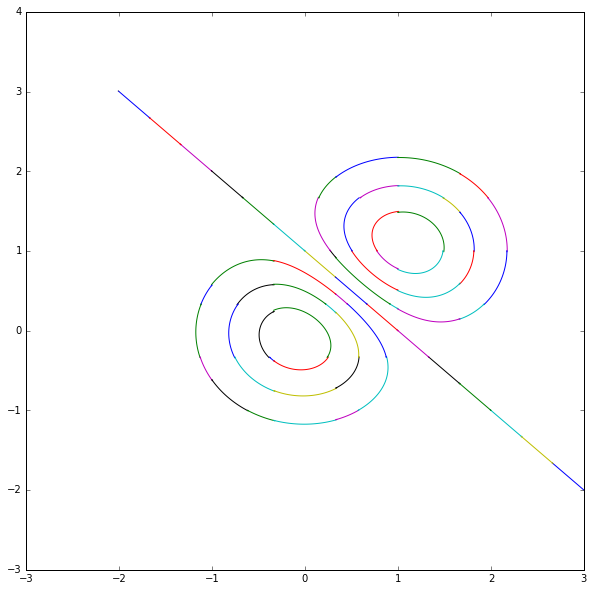

In [17]:
plt.figure(figsize=(10,10))
for i in [0,1,0.5,1.5,-0.5,-1,-1.5]:
    trace(f,np.linspace(-3,3,10),np.linspace(-3,3,10),i)


## Visualisation des lignes de niveau en 3D

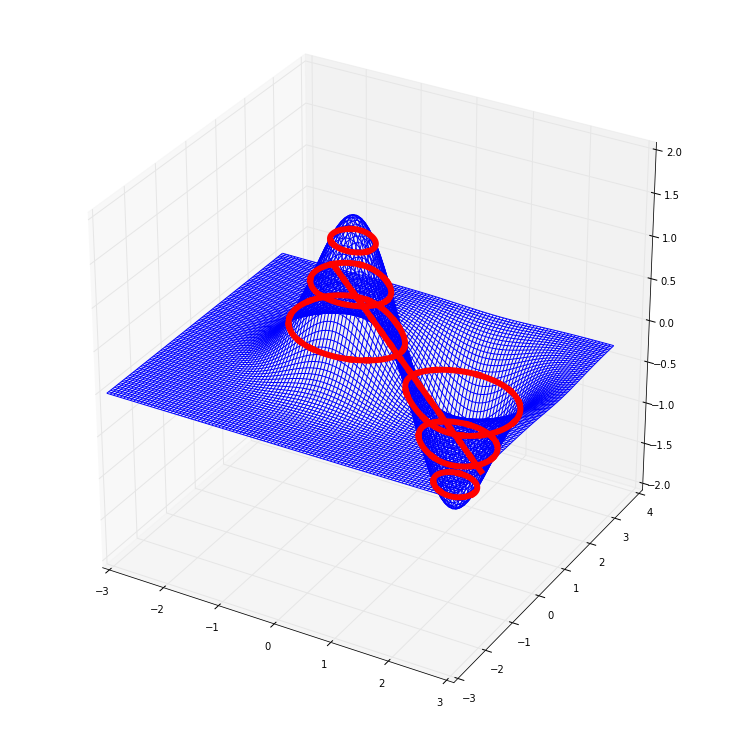

In [18]:

domain_x=np.linspace(-3,3,100)
domain_y=np.linspace(-3,3,100)
X,Y=np.meshgrid(domain_x,domain_y)
         
Z=f([X,Y])
fig=plt.figure(figsize=(10,10))

ax=Axes3D(fig)

ax.plot_wireframe(X,Y,Z, label="plot")
def trace(g,xc,yc,c=0):
    a,b=contour_complexe(f,c,np.linspace(-3,3,10),np.linspace(-3,3,10))
    for x,y in zip(a,b):
        ax.plot(x,y,c,'r',linewidth=6)
        
for i in [0,1,0.5,1.5,-0.5,-1,-1.5]:
    trace(f,np.linspace(-3,3,10),np.linspace(-3,3,10),i)


# Plus grande Précision

- Comme présenté précedemment dans la premère technique l'erreur s'accumule et notre courbe de niveau dérive par rapport à la réalité. On va donc corriger chaque point obtenu par la première méthode en le remplaçant par un point réellement sur la courbe de niveau.
- Ce point $ (x,y)$ doit vérifier $f(x,y)=c$, mais aussi appartenir au cercle de centre le point précédent $(x_i,y_i)$ et de rayon $\delta$ ; c'est à dire vérifier  : $(x-x_i)^2+(y-y_i)^2-\delta^2=0$
- Déterminer ce nouveau point, c'est résoudre le système $H(x,y)=(0,0) où H(X)=\begin{pmatrix} f(x,y)-c   \\(x-x_i)^2+(y-y_i)^2 \end{pmatrix}$
- On peut alors utiliser la méthode de Newton que l'on initialise en $(x_e,y_e)$, coordonnées du point  données par la méthode dite de la tangente. La formule de récurrence dans notre cadre devient $X_{k+1}=X_k-J_H(X_k)^{-1}.H(X_k)$. On aura vérifié au préalable que la matrice est bien inversible.
- Encore une fois on arrête l'itération lorsque on a atteint une précision au moins égale à $\epsilon = 2^{-26=}$

In [19]:
def simple_contour(g,xc,yc,nom_bord,i,j,c=0,delta=0.001,eps=2**(-26)):
    abscisses , ordonnées = [],[]
    dic_fonction = {"UP" : find_seed_U, "LEFT":find_seed_L, "RIGHT" : find_seed_R,"DOWN" : find_seed_D }
    position = dic_fonction[nom_bord](g,c,[xc[i],xc[i+1]], [yc[j],yc[j+1]])
    gradg=autograd.grad(g)
    if  not isinstance( position,list) :
        return [],[]
    else:
        position = np.array(position)     
        abscisses.append(position[0])
        ordonnées.append(position[1])

        def test (position):
            return xc[i]<=position[0]<=xc[i+1] and yc[j]<=position[1]<=yc[j+1]
        while test(position) :
            gradX=gradg(position)
            norme = np.sqrt(gradX[1]**2+gradX[0]**2)
            vect = np.array([gradX[1]/norme,-1*gradX[0]/norme])
            position_faux = position + vect*delta
            position1=position

            def h1 (x,y):
                return g(np.array([x,y]))-c
            def h2 (x,y):
                return (x - position1[0])**2 + (y - position1[1])**2 - delta**2
            def H(x,y) : 
                return np.array([h1(x,y),h2(x,y)])
            
            def J_H(x,y):
                
                j = autograd.jacobian
                return np.c_[j(H, 0)(x,y), j(H, 1)(x,y)]
            
            
            J=J_H(position_faux[0],position_faux[1])
            if np.linalg.det(J)==0:
                abscisses.append(position_faux[0])
                ordonnées.append(position_faux[1])
            else:

                J_inv=np.linalg.inv(J)
                position=position_faux -J_inv@H(position_faux[0],position_faux[1])
                while np.linalg.norm(position-position_faux)>eps:
                    position_faux=position
                    J=J_H(position_faux[0],position_faux[1])
                    if np.linalg.det(J)==0:
                        break
                    else:
                        J_inv=np.linalg.inv(J)
                        position=position_faux -J_inv@H(position_faux[0],position_faux[1])
                abscisses.append(position[0])
                ordonnées.append(position[1])

        return abscisses,ordonnées

In [20]:
def contour_complexe(f, c=0, xc = [0,1], yc = [0,1], delta = 0.01):
    xs,ys= [], []

    liste_bord = ['UP','LEFT','RIGHT','DOWN']
    for i in range(len(xc)-1):
        for j in range(len(yc)-1):
            for nom_bord in liste_bord :
                X,Y=simple_contour(f,xc,yc,nom_bord,i,j,c,delta)
                xs.append(X)
                ys.append(Y)
    return xs,ys

In [21]:
def trace(g,xc,yc,c=0):
    a,b=contour_complexe(g,c,xc,yc)
    for x,y in zip(a,b):
        plt.plot(x,y)
        

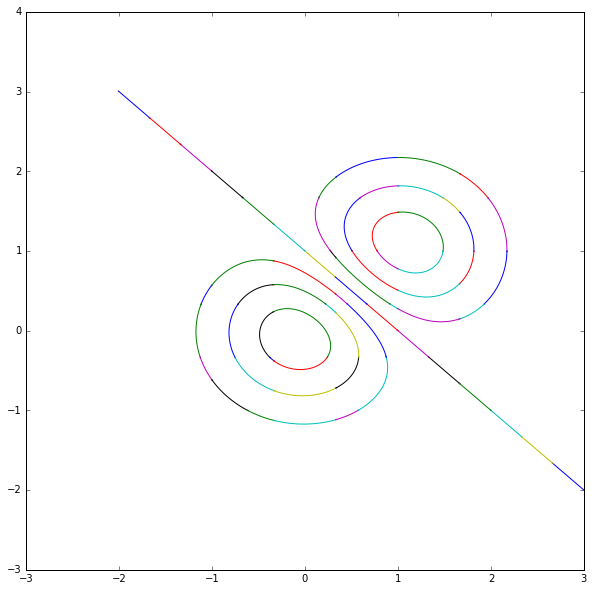

In [22]:
plt.figure(figsize=(10,10))
for i in [0,1,0.5,1.5,-0.5,-1,-1.5]:
    trace(f,np.linspace(-3,3,10),np.linspace(-3,3,10),i)

## Erreur
Contrairement au cas précédent, l'erreur est fortement réduite.
- En effet, dans le cas précédent, l'erreur se propageait le long de la courbe de niveau dans chaque case.
- Avec la méthode 'plus précise', l'erreur est corrrigé à chaque point. 

Comme on peut le voir sur le 1er graphe ci-dessous, les points pour {delta = 0.5} et ceux pour {delta = 0,01} correspondent tous à {epsilon = 2**(-26)} près.** Il n'y a donc pas propagation de l'erreur.

De plus, le deuxième graphe montre que l'erreur est immédiatement réduite à une valeur proche de zéro. On ne distingue plus d'augmentation avec le nombre d'itérations. 

**Ce modèle est donc satisfaisant.**

[0.0, 0.4841229216424573, 0.8472151090268372, 0.9985035191545077, 0.9001660494935515] [0.9999999850988388, 0.874999998137355, 0.5312499967403712, 0.05468749615829466, -0.4355468784633556]


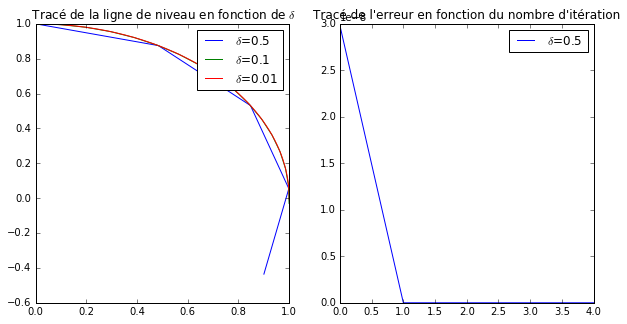

In [26]:
a=simple_contour(g,[0,1],[0,1],'LEFT',0,0,1,0.5)
b=simple_contour(g,[0,1],[0,1],'LEFT',0,0,1,0.1)
c=simple_contour(g,[0,1],[0,1],'LEFT',0,0,1,0.01)
plt.close()
plt.figure(figsize=(10,5))
print(a[0],a[1])
plt.subplot(121)
plt.title(" Tracé de la ligne de niveau en fonction de $\delta$")
plt.plot(a[0],a[1],label='$\delta$=0.5')
plt.plot(b[0],b[1],label='$\delta$=0.1')
plt.plot(c[0],c[1],label='$\delta$=0.01')
plt.legend()
plt.subplot(122)
plt.plot(abs((np.array(a[0])**2+np.array(a[1])**2)-1),label='$\delta$=0.5')
#plt.plot(abs((np.array(b[0])**2+np.array(b[1])**2)-1),label='$\delta$=0.1')
#plt.plot(abs((np.array(c[0])**2+np.array(c[1])**2)-1),label='$\delta$=0.01')
plt.title("Tracé de l'erreur en fonction du nombre d'itération")
plt.legend()

